## Fast ai lesson 2

import packages

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
import inspect


from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


### Part 1

Training a linear model with keras 

In [2]:
#dummy data
x = np.random.randn(30,2)
y = np.dot(x,[2.,3.])+1
print(x[:5])
print(y[:5])

[[ 2.5812  0.4294]
 [-0.866   0.3251]
 [-1.1786  0.2658]
 [-1.1868  0.8272]
 [ 1.2949 -1.1161]]
[ 7.4507  0.2434 -0.5597  1.1079  0.2415]


In [3]:
#define a linear model with keras
lm = Sequential()
lm.add(Dense(1,input_shape=(2,)))
lm.compile(optimizer = SGD(lr = 0.1),loss = 'mse')
print(lm.evaluate(x,y,verbose=0))
lm.fit(x,y,nb_epoch=5,batch_size=1,verbose= 1)
print(lm.evaluate(x,y,verbose=0))

13.3191947937
Epoch 1/5
30/30 [==============================] - 0s - loss: 3.0997     
Epoch 2/5
30/30 [==============================] - 0s - loss: 4.2116e-04     
Epoch 3/5
30/30 [==============================] - 0s - loss: 2.8343e-08     
Epoch 4/5
30/30 [==============================] - 0s - loss: 1.1487e-13     
Epoch 5/5
30/30 [==============================] - 0s - loss: 8.6094e-14     

## Part 2 

Using the output from CNN and use a NN layer

In [4]:
path = '../data/dogscats/'
model_path = path + 'models/'
if not os.path.exists(model_path) : os.mkdir(model_path)

Start with Vgg model
* get the true labels for every image 
* get the 1000 image net category for every image 
* feed the prediction to a simple linear model 

In [5]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
batch_size = 100 #reduce if your gpu does not have enough memory 

Pre processing steps and learning bcolz

In [7]:
inspect.getsourcelines(get_batches)

(["def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',\n",
  '                target_size=(224,224)):\n',
  '    return gen.flow_from_directory(dirname, target_size=target_size,\n',
  '            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)\n'],
 89)

note, the code below is not be required due to changes in the get_data function.

Nevertheless, it is still good to know since `get_data` uses `get_batches`

In [8]:
val_batches = get_batches(path + 'valid', shuffle= False, batch_size=batch_size)
batches = get_batches(path + 'train',shuffle = False, batch_size = batch_size)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


#### loading data and using bcolz

Note that if you attempt to train the follwing model with `get_data`, you will run out of ram. 


In [9]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

inspect.getsourcelines(get_data)

(['def get_data(path, target_size=(224,224)):\n',
  '    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)\n',
  '    return np.concatenate([batches.next() for i in range(batches.nb_sample)])\n'],
 135)

In [ ]:
#saving them into the path using bcolz
val_data = get_data(path + 'valid') #error from orginial code
trn_data = get_data(path + 'train') #error from orginial code
save_array(model_path + 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc',val_data)

In [10]:
trn_data = load_array(model_path + 'train_data.bc')
val_data = load_array(model_path + 'valid_data.bc')

In [11]:
print(trn_data.shape)

print(sys.getsizeof(val_data))
print(sys.getsizeof(trn_data))

(23000, 3, 224, 224)
2408448144
27697152144


In [12]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense()) #perform one hot encoding

In [13]:
val_classes = val_batches.classes 
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
print(trn_labels.shape)

(23000, 2)


In [14]:
print(trn_labels.sum(axis=0))

[ 11500.  11500.]


Extracting the 1000 output probs from the vgg model

In [15]:
trn_features = model.predict(trn_data, batch_size = batch_size)
val_features = model.predict(val_data, batch_size = batch_size)
print(trn_features.shape)
save_array(model_path+ 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

(23000, 1000)


In [16]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [17]:
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

batch_size=64

lm.fit(trn_features, trn_labels, nb_epoch=10, batch_size=batch_size, 
       validation_data=(val_features, val_labels))


Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 0s - loss: 0.1096 - acc: 0.9610 - val_loss: 0.0939 - val_acc: 0.9645

In [18]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 2)             2002        dense_input_2[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


### Part 2 - visualizing the model errors

In [34]:
#predict the classes 
preds = lm.predict_classes(val_features, batch_size = batch_size)
#and the probabilities 
probs = lm.predict_proba(val_features, batch_size = batch_size)
probs = probs[:,0] #extract the first axis


1920/2000 [===========================>..] - ETA: 0s

In [33]:
print(probs[:20]) #print first eight elements

[ 1.      1.      1.      1.      1.      1.      1.      1.      0.1242  0.9689  1.      1.      1.
  1.      1.      1.      0.9721  1.      1.      1.    ]


In [42]:
filenames = val_batches.filenames #extract the file names
n_view = 4 
def plot_idx(idx,titles = None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles = titles)

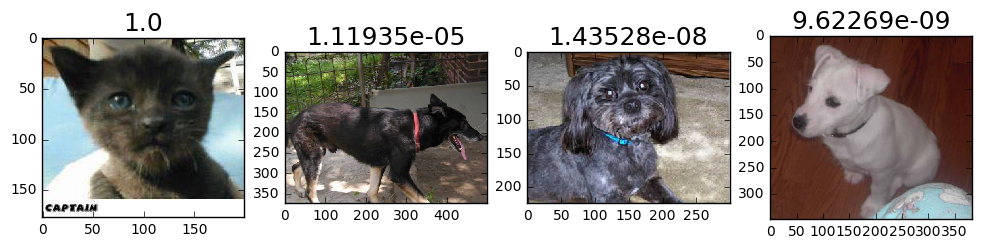

In [43]:
#correct dogs and correct predictions
correct = np.where(preds == val_labels[:,1])[0]
idx = permutation(correct)[:n_view] #extract the first 4 elements 
plot_idx(idx,probs[idx])

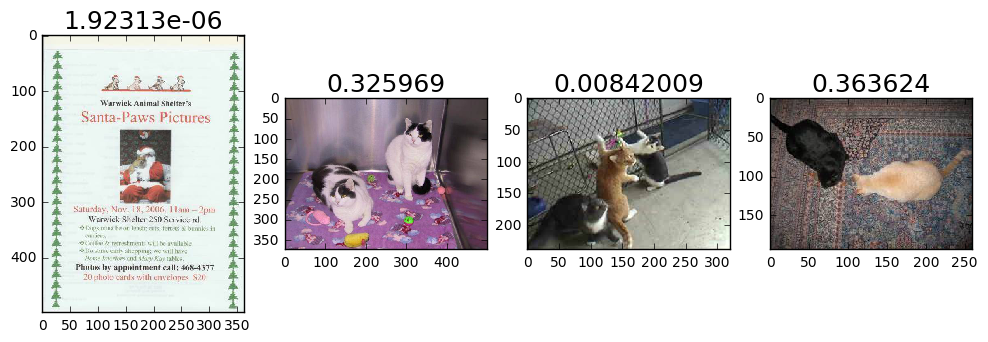

In [44]:
#predict dogs but actually acts
false_dogs = np.where(preds != val_labels[:,1])[0]
idx = permutation(false_dogs)[:n_view]
plot_idx(idx,probs[idx])

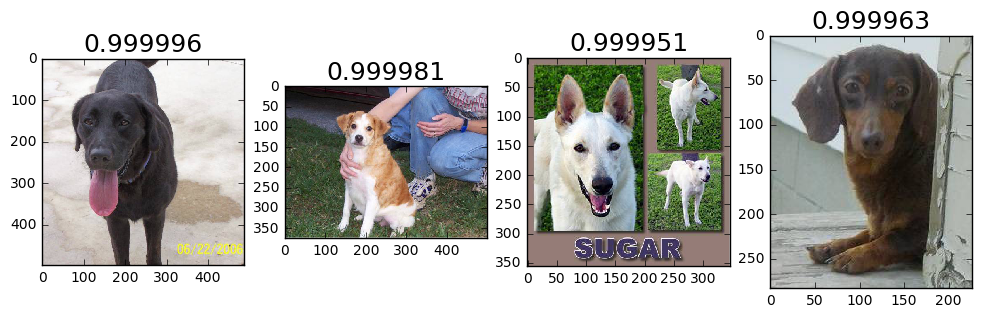

In [54]:
#super sure dogs 
correct_dogs = np.where((probs <= 0.0001) & (preds == val_labels[:,1]))[0]
idx = permutation(correct_dogs)[:n_view] #extract the first 4 elements 
plot_idx(idx,1-probs[idx])

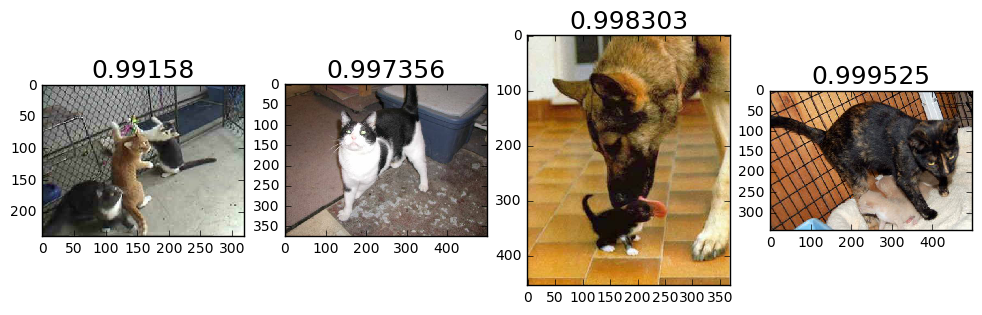

In [56]:
#super sure dogs, but turns out to be cats 
strong_false_dogs = np.where((probs <= 0.01) & (preds != val_labels[:,1]))[0]
idx = permutation(strong_false_dogs)[:n_view] #extract the first 4 elements 
plot_idx(idx,1-probs[idx])

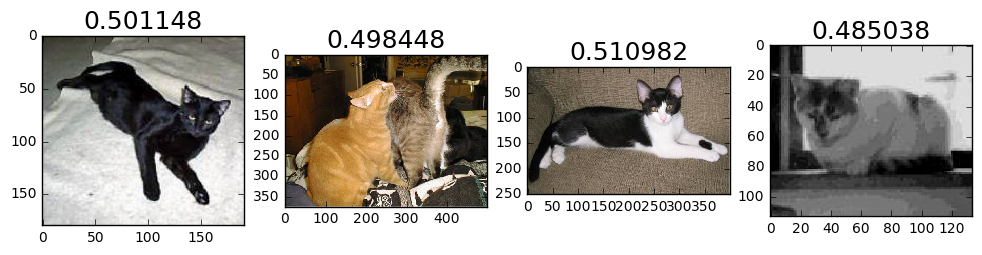

In [58]:
#uncertain
most_uncertain = np.argsort(np.abs(probs-0.5))
plot_idx(most_uncertain[:n_view], probs[most_uncertain])

[[954  46]
 [ 20 980]]


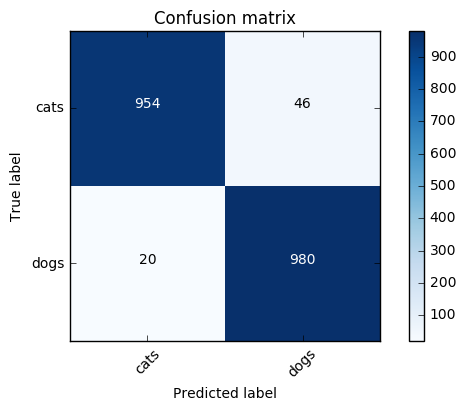

In [60]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

# Part 3 

removing the last layer of the vgg network 

In [91]:
# to see the model layers, 
#vgg.model.summary()

In [92]:
#remove the last layer 
model.pop()
for layer in model.layers: layer.trainable = False 

In [93]:
model.add(Dense(2,activation='softmax'))


In [94]:
#using keras 
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data,trn_labels,batch_size= batch_size, shuffle = True)
val_batches = gen.flow(val_data,val_labels, batch_size = batch_size, shuffle = False )


In [95]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, 
                        samples_per_epoch= batches.n, #error
                        nb_epoch = nb_epoch,
                        validation_data = val_batches,
                        nb_val_samples = val_batches.n) #error

In [96]:
opt = RMSprop(lr = 0.1) 
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

In [97]:
fit_model(model,batches, val_batches, nb_epoch= 2)

Epoch 1/2
23000/23000 [==============================] - 633s - loss: 1.0569 - acc: 0.9318 - val_loss: 0.7898 - val_acc: 0.9510

In [98]:
model.save_weights(model_path+'finetune1.h5')


In [99]:
model.load_weights(model_path+'finetune1.h5')


In [100]:
model.evaluate(val_data, val_labels)


2000/2000 [==============================] - 51s     

[0.58831249377562722, 0.96350000000000002]

2000/2000 [==============================] - 51s     

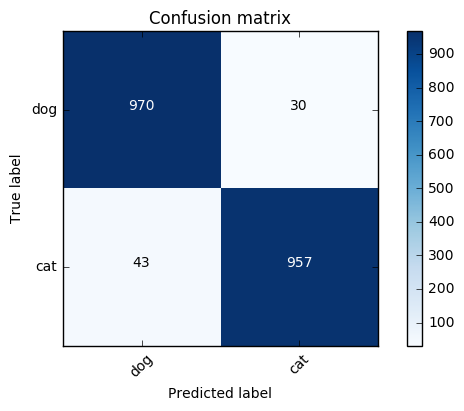

In [101]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
print(probs[:8])
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})


### Part 4 

Retraining all the dense layers

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [102]:
#retraining only the dense layers 
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

In [103]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
23000/23000 [==============================] - 635s - loss: 0.9934 - acc: 0.9381 - val_loss: 0.5543 - val_acc: 0.9650

In [104]:
model.save_weights(model_path+'finetune2.h5')


In [114]:
model.evaluate(val_data,val_labels, batch_size= 200)

2000/2000 [==============================] - 51s     


[0.55751974582672115, 0.96500000357627869]

### Part 5 

Retrain the conv layers as well - note that there is not much improvement

In [115]:
#to retrain the conv layers 
for layer in layers[12:]: layer.trainable=True
    
K.set_value(opt.lr, 0.001)

fit_model(model,batches, val_batches , 4)

Epoch 1/4
23000/23000 [==============================] - 635s - loss: 0.9484 - acc: 0.9409 - val_loss: 0.5561 - val_acc: 0.9655

In [116]:
model.save_weights(model_path + 'finetune3.h5')

In [119]:
#Evaluate by the generator
model.load_weights(model_path + 'finetune2.h5')
model.evaluate_generator(get_batches(path + 'valid/', gen, False, batch_size*2), val_batches.n)


Found 2000 images belonging to 2 classes.


[0.55751978111267086, 0.96499999999999997]